In [1]:
# loading necessary library
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import math
import numpy as np
import random

In [2]:
# Creating dataset
random.seed(0)
list_1 = ['investment period 1', 'investment period 2', 'investment period 3', 'investment period 4', 'investment period 5', 'investment period 6', 
          'investment period 7', 'investment period 8', 'investment period 9', 'investment period 10']
# list_1 = ['investment period 1', 'investment period 2', 'investment period 3', 'investment period 4', 'investment period 5']
list_2 = []
for i in range(5):
    list_2.append(str(i + 1))  
list_3 = ['s', 'b']

import random
def original():
    dictionary = {}
    for element_1 in list_1:
        dictionary[element_1] = {}
        for element_2 in list_2:
            dictionary[element_1][element_2]={}
            for element_3 in list_3:
                dictionary[element_1][element_2][element_3] = round(random.uniform(1, 1.3),2)
                
    return dictionary

In [3]:
# calling method for creating dictinary of dataset
returns = original()

In [4]:
# print purpose
print('Dataset')
print('=======')
for key, value in returns.items():
    print(key)
    for k,v in returns[key].items():
        
        print(k, ' : ', v)

Dataset
investment period 1
1  :  {'s': 1.25, 'b': 1.23}
2  :  {'s': 1.13, 'b': 1.08}
3  :  {'s': 1.15, 'b': 1.12}
4  :  {'s': 1.24, 'b': 1.09}
5  :  {'s': 1.14, 'b': 1.18}
investment period 2
1  :  {'s': 1.27, 'b': 1.15}
2  :  {'s': 1.08, 'b': 1.23}
3  :  {'s': 1.19, 'b': 1.08}
4  :  {'s': 1.27, 'b': 1.29}
5  :  {'s': 1.24, 'b': 1.27}
investment period 3
1  :  {'s': 1.09, 'b': 1.22}
2  :  {'s': 1.27, 'b': 1.21}
3  :  {'s': 1.14, 'b': 1.03}
4  :  {'s': 1.13, 'b': 1.18}
5  :  {'s': 1.27, 'b': 1.29}
investment period 4
1  :  {'s': 1.14, 'b': 1.26}
2  :  {'s': 1.08, 'b': 1.24}
3  :  {'s': 1.16, 'b': 1.0}
4  :  {'s': 1.22, 'b': 1.12}
5  :  {'s': 1.25, 'b': 1.2}
investment period 5
1  :  {'s': 1.0, 'b': 1.15}
2  :  {'s': 1.26, 'b': 1.07}
3  :  {'s': 1.1, 'b': 1.26}
4  :  {'s': 1.06, 'b': 1.17}
5  :  {'s': 1.07, 'b': 1.29}
investment period 6
1  :  {'s': 1.24, 'b': 1.13}
2  :  {'s': 1.02, 'b': 1.1}
3  :  {'s': 1.15, 'b': 1.28}
4  :  {'s': 1.03, 'b': 1.17}
5  :  {'s': 1.21, 'b': 1.16}
investm

In [5]:
def original():
    dictionary = {}
    for element_1 in list_2:
        dictionary[element_1] = 1/len(returns['investment period 1'].keys())
    return dictionary

probs = original()
print(probs)

# probs = {'1' : 0.20, '2' : 0.20, '3': 0.20, '4': .20, '5': .20}
pos = {}

# for n investment periods change numEpochs to n
numEpochs = 7

# This variable helps to verify number of nodes in the messy situation (for higher numEpochs)
tree_calc = numEpochs

# It's the distance from one investment period to other in the graph (value is not crucial)
horizDist = 12

# used to place high, low situations to the opposite direction
slopes = [-2,-1,0,1,2]

{'1': 0.2, '2': 0.2, '3': 0.2, '4': 0.2, '5': 0.2}


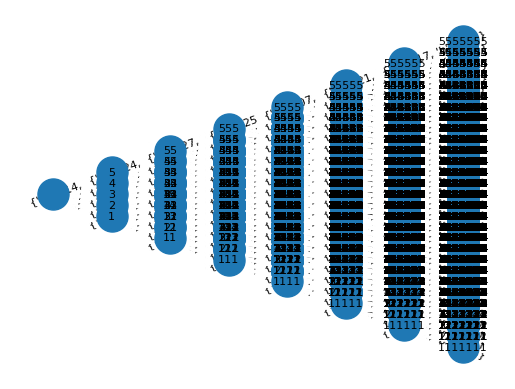

In [6]:
# root is "", t is for , j is for the investment period
def buildGraph(G, root, t, j):
    newX = pos[root][0] + horizDist
    yBase = pos[root][1]
    
    index = 0
    for i in returns['investment period ' + str(j)].keys():
        # print('H/L: ',i)
        newNode = root + i
        # print('newnode:',newNode)
        G.add_edge(root, newNode, p = probs[i], returns = returns['investment period ' + str(j)][i])
        G.add_node(newNode)
        pos[newNode] = [newX, yBase + horizDist*slopes[index]]
        # pos[newNode] = [newX, yBase + horizDist*next(alternator)]
        if t < numEpochs - 1:
            buildGraph(G, newNode, t + 1, j + 1)
        index += 1

G = nx.DiGraph()
G.add_node("")
pos[""] = [0, 0]
buildGraph(G, "", 0, 1)

edge_labels = nx.get_edge_attributes(G,'returns')
plt.figure()
nx.draw_networkx(G,pos,node_size=500, font_size = 8)
nx.draw_networkx_edge_labels(G,pos,edge_labels, font_size = 8)
plt.axis('off')
plt.show()

In [7]:
# number of nodes including "" at the very beginning
len(list(G.nodes))

97656

In [8]:
# to verify number of nodes mathematically
import math
sum = 1
numEpochs = tree_calc
for i in range(numEpochs):
    sum = sum + math.pow(len(returns['investment period 1'].keys()), numEpochs)
    numEpochs -= 1
print(sum)

97656.0


# Gurobi Code

In [9]:
import gurobipy as gp
from gurobipy import GRB
import itertools

def getPredNode(G, node):
    return [pred for pred in G.predecessors(node)][0]

def getReturn(G, node, i):
    value = ''
    # j = 'time horizon ' + str(j)
    for u, v, data in G.in_edges(node, data = True):
        value = data['returns'][i]
        
    return value

investments = ['s', 'b']

## currently, G.out_degree(x) == 5 since we have 5 scenarios exiting each node
branchNodes = [x for x in G.nodes() if G.out_degree(x)==5 and G.in_degree(x)==1]

decisionNodes = branchNodes + ['']
leafNodes = [x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1]
p = 1/len(leafNodes)

    
try:
    m = gp.Model("Financial Planning - Decision Tree Model")
    m.setParam('OutputFlag', 0)
    
    x = m.addVars(itertools.product(investments, decisionNodes), name = "invest")
 
    y = m.addVars(leafNodes, name = "excess")
    w = m.addVars(leafNodes, name = "shortage")
    
    m.setObjective(p * gp.quicksum([y[l] - 4*w[l] for l in leafNodes]), GRB.MAXIMIZE)

    m.addConstr(x.sum('*',"") <= 30, "investAmountAtNode['0']")
    m.addConstrs((x.sum('*', n) == gp.quicksum([getReturn(G, n, i)*x[i, getPredNode(G,n)] for i in investments]) for n in branchNodes), "investAmountAtNode")
    m.addConstrs((200 == gp.quicksum([getReturn(G, l, i)*x[i, getPredNode(G,l)] for i in investments]) - y[l] + w[l] for l in leafNodes), "final")
    
    m.write('financial_plan_with_10_investment_periods.lp')
    
except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))
except AttributeError:
    print('Encountered an attribute error')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-20


In [10]:
# !cat financial_plan_with_10_investment_periods.lp

In [11]:
try:
    
    m.optimize()
    
    for v in m.getVars(): print('%s %g' % (v.VarName, v.X))

    print('Obj: %g' % m.ObjVal)
   
    # print("invest s,1", investments[0],decisionNodes[0])
    
except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))
except AttributeError:
    print('Encountered an attribute error')

invest[s,1] 37.5
invest[s,11] 0
invest[s,111] 58.1025
invest[s,1111] 0
invest[s,11111] 0
invest[s,111111] 86.0748
invest[s,111112] 83.7896
invest[s,111113] 97.5006
invest[s,111114] 89.1217
invest[s,111115] 88.36
invest[s,11112] 0
invest[s,111121] 80.087
invest[s,111122] 77.9608
invest[s,111123] 90.718
invest[s,111124] 82.9219
invest[s,111125] 82.2132
invest[s,11113] 0
invest[s,111131] 94.308
invest[s,111132] 91.8043
invest[s,111133] 106.827
invest[s,111134] 97.6464
invest[s,111135] 96.8118
invest[s,11114] 0
invest[s,111141] 87.5717
invest[s,111142] 85.2468
invest[s,111143] 99.1963
invest[s,111144] 90.6716
invest[s,111145] 89.8967
invest[s,11115] 0
invest[s,111151] 96.5535
invest[s,111152] 93.9901
invest[s,111153] 109.37
invest[s,111154] 99.9713
invest[s,111155] 99.1168
invest[s,1112] 0
invest[s,11121] 0
invest[s,111211] 81.5445
invest[s,111212] 79.3796
invest[s,111213] 92.369
invest[s,111214] 84.4311
invest[s,111215] 83.7094
invest[s,11122] 0
invest[s,111221] 75.8719
invest[s,111222] 7

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

